In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score

from mealpy import FloatVar, ARO

import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('D:/KLTN/STOCK-PREDICTION/data/FPT.csv')

In [50]:
data.head(10)

,Unnamed: 0,time,open,high,low,close,volume
0,0,1/4/2021,222.53,223.00,214.81,217.69,37130139
1,1,1/5/2021,217.26,218.52,215.70,217.90,23822953
2,2,1/6/2021,212.17,216.49,211.94,212.25,35930653
3,3,1/7/2021,214.04,219.34,213.71,218.29,27694480
4,4,1/8/2021,218.68,220.58,217.03,219.62,22956206
5,5,1/11/2021,218.47,218.91,216.73,217.49,23047029
6,6,1/12/2021,216.50,217.10,213.32,214.93,23249336
7,7,1/13/2021,214.02,216.76,213.93,216.34,20087080
8,8,1/14/2021,215.91,217.46,212.74,213.02,29346737
9,9,1/15/2021,213.52,214.51,212.03,212.65,31746512


In [5]:
print(x_train.shape)  # In ra kích thước của x_train
print(x_test.shape)   # In ra kích thước của x_test


(1340, 60, 1)
(290, 60, 1)


In [3]:
def process_data(data):
    #định dạng lại cấu trúc thời gian
    data['time']=pd.to_datetime(data.time, format='mixed' ,dayfirst=False)

    #Lấy cột Close
    data=data[['close']]

    # Chia tập dữ liệu thành train/test (80% train, 20% test)
    x_train, x_test = train_test_split(data, test_size=0.2, shuffle=False)

    # Khởi tạo scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit scaler trên tập huấn luyện và transform cả train lẫn test
    train_scaled = scaler.fit_transform(x_train)
    test_scaled = scaler.transform(x_test)

    #Tạo vòng lặp giá trị, lấy 60 ngày trong quá khứ để dự đoán ngày tiếp theo
    x_train = []
    y_train = []
    for i in range(60, len(train_scaled)):
        x_train.append(train_scaled[i-60:i, 0])
        y_train.append(train_scaled[i, 0])

    x_test = []
    y_test = []
    for i in range(60, len(test_scaled)):
        x_test.append(test_scaled[i-60:i, 0])
        y_test.append(test_scaled[i, 0])

    #Chuyển dạng list sang dạng mảng numpy
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    #Xếp dữ liệu thành mảng 1 chiều
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, scaler, test_scaled

In [4]:
x_train, y_train, x_test, y_test, scaler, test_scaled = process_data(data)

In [5]:
#Model LSTM

#Xây dựng mô hình LSTM
def LSTM_model(lstm_unit1,lstm_unit2 ,dropout_rate, dense_unit):

    lstm_model = Sequential()
    lstm_model.add(LSTM(units=int(lstm_unit1),return_sequences=True, input_shape=(x_train.shape[1],1)))
    lstm_model.add(Dropout(dropout_rate))
    lstm_model.add(LSTM(units=int(lstm_unit2)))
    lstm_model.add(Dropout(dropout_rate))
    lstm_model.add(Dense(int(dense_unit), activation='relu'))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    return lstm_model


In [91]:
#Huấn luyện mô hình MSFT
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(128, 128, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0532 - val_loss: 0.0173
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0022 - val_loss: 0.0045
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0021 - val_loss: 0.0106
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0

In [22]:
#Huấn luyện mô hình FPT
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(128, 128, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - loss: 0.0567 - val_loss: 0.0677
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0029 - val_loss: 0.0333
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 0.0023 - val_loss: 0.0364
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0023 - val_loss: 0.0300
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0021 - val_loss: 0.0250
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0021 - val_loss: 0.0669
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0022 - val_loss: 0.0186
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0023 - val_loss: 0.0780
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0020 - val_loss: 0.0408
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0019 - val_loss: 0.0614
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0016 - val_loss: 0.0516
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 

In [74]:
#Huấn luyện mô hình BID
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(128, 128, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0484 - val_loss: 0.0155
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0035 - val_loss: 0.0230
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0

In [22]:
#Huấn luyện mô hình HPG
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(128, 128, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - loss: 0.0415 - val_loss: 0.0016
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0028 - val_loss: 5.4472e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0024 - val_loss: 9.2741e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0021 - val_loss: 4.2271e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0016 - val_loss: 4.2413e-04
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0017 - val_loss: 8.2755e-04
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 0.0014 - val_loss: 6.4520e-04
Epoch 12/100
42/

In [11]:
#Huấn luyện mô hình VCB
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(128, 128, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - loss: 0.0562 - val_loss: 0.0028
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0026 - val_loss: 8.6628e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0027 - val_loss: 9.7020e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0022 - val_loss: 7.1859e-04
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0021 - val_loss: 6.2855e-04
Epoch 12/100
42/42 ━━━━━

In [58]:
#Huấn luyện mô hình MWG
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(128, 128, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0415 - val_loss: 0.0015
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0025 - val_loss: 0.0046
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0021 - val_loss: 8.9418e-04
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0021 - val_loss: 9.0248e-04
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0019 - val_loss: 8.8603e-04
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step

In [25]:
lstm_model.save('D:/KLTN/STOCK-PREDICTION/trained/LSTM-FPT-128.h5')

In [32]:
lstm_model = tf.keras.models.load_model('D:/KLTN/STOCK-PREDICTION/trained/LSTM-FPT-128.h5')

In [ ]:
#Dự đoán trên tập test
predict = lstm_model.predict(x_test)
prediction_test_price = scaler.inverse_transform(predict)
actual_test_price = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step


In [ ]:
#Tính toán các chỉ số đánh giá # MSFT
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.03328625052494705
MAE:  0.025838340901933037
R-squared:  0.8557119226364074


In [ ]:
#Tính toán các chỉ số đánh giá # MWG
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.017426202013618605
MAE:  0.013444581092129702
R-squared:  0.9892037509743288


In [ ]:
#Tính toán các chỉ số đánh giá # FPT
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.18217704918938737
MAE:  0.15137832453943686
R-squared:  0.7878134783297897


In [ ]:
#Tính toán các chỉ số đánh giá # BID
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.02894460997003043
MAE:  0.021122547053933856
R-squared:  0.9471361640857331


In [ ]:
#Tính toán các chỉ số đánh giá # HPG
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.01194593784708938
MAE:  0.009098427352887437
R-squared:  0.9242483678804102


In [ ]:
#Tính toán các chỉ số đánh giá #VCB
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.019060069704287082
MAE:  0.013167358687893434
R-squared:  0.8705053627609256


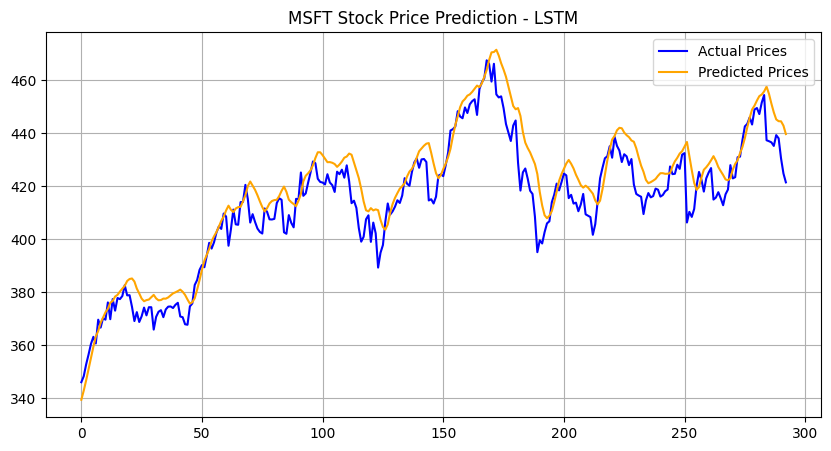

In [95]:
#Vẽ biểu đồ  #MSFT

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('MSFT Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

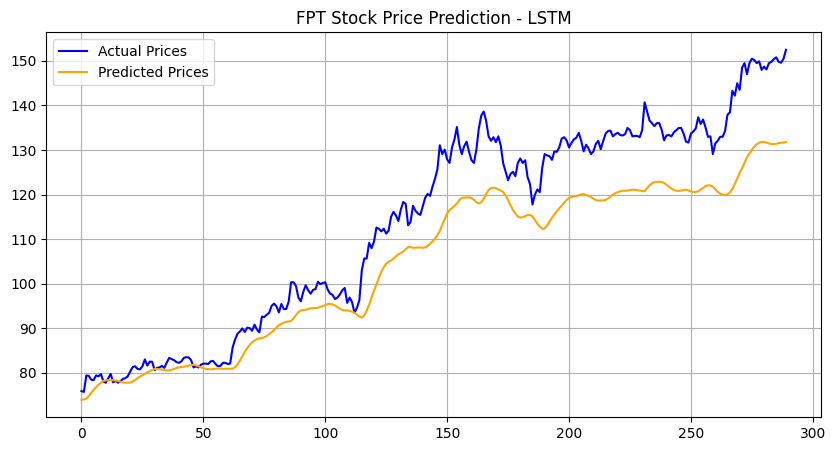

In [35]:
#Vẽ biểu đồ FPT

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('FPT Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

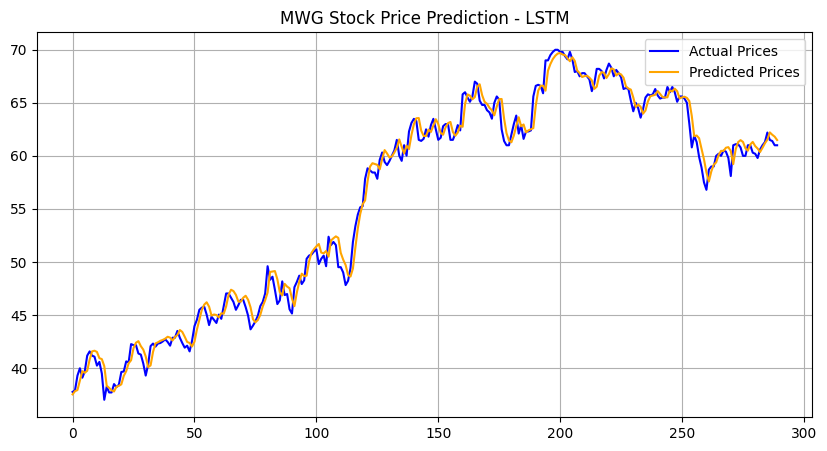

In [114]:
#Vẽ biểu đồ MWG

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('MWG Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

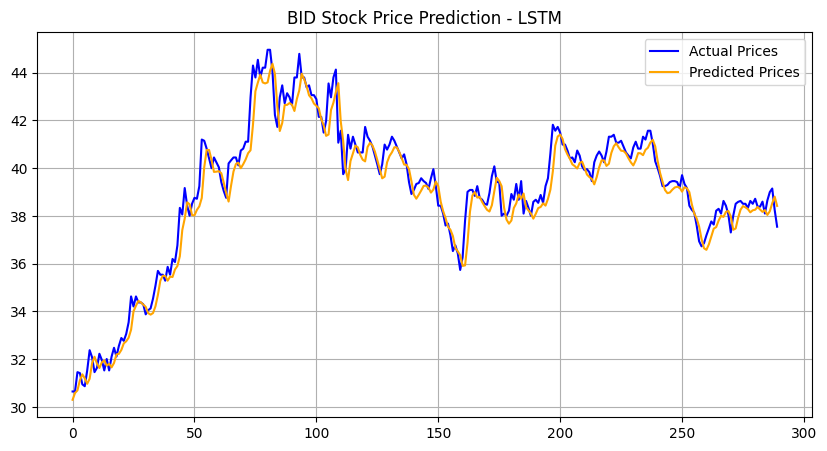

In [87]:
#Vẽ biểu đồ BID

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('BID Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

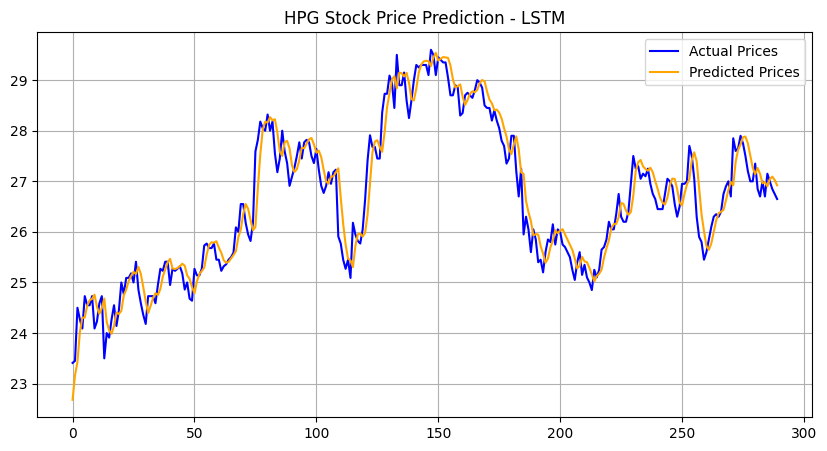

In [109]:
#Vẽ biểu đồ HPG

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('HPG Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

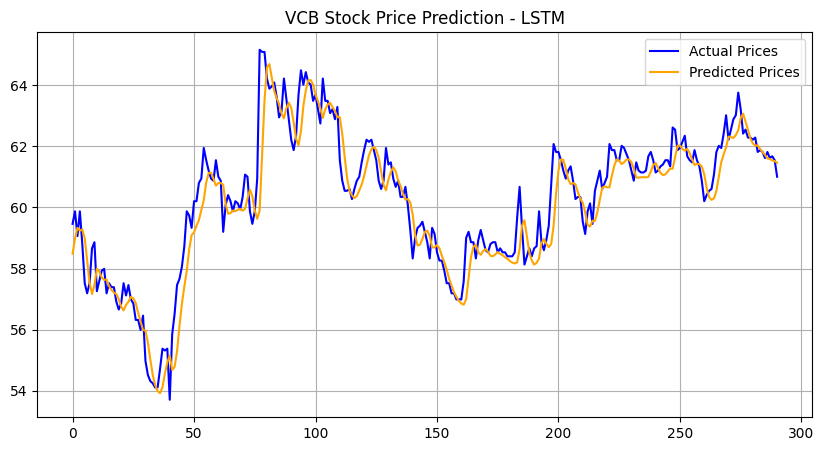

In [14]:
#Vẽ biểu đồ VCB

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('VCB Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def predict(scaler, test_scaled):
    #Chuẩn bị dữ liệu để dự đoán 30 ngày tiếp theo
    last_day = 60
    predicted_values = []
    last_n_day = test_scaled[-last_day:]

    #Tạo dự đoán 10 ngày tiếp theo
    for _ in range(10):
        #Dự đoán giá trị tiếp theo
        pred = lstm_model.predict(last_n_day.reshape((1,last_n_day.shape[0],1)))
        predicted_values.append(pred[0,0])

        #Cập nhật last_n_day cho lần dự đoán tiếp theo, thêm giá trị dự đoán mới và loại bỏ giá trị cũ đi
        last_n_day = np.append(last_n_day[1:],[[pred[0,0]]], axis=0)

    predicted_values = np.array(predicted_values)
    predicted_values = predicted_values.reshape(-1,1)
    predicted_values = scaler.inverse_transform(predicted_values)

    return predicted_values

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━